# 聚类分析之种子数据集

## 一、数据集介绍

数据集采用[UCI的Seeds Data Set](http://archive.ics.uci.edu/ml/datasets/seeds#)（关于小麦品种的籽粒数据集）其中包含210条数据，每条数据由7个属性外加1个类别组成，数据集总共分为3类。

七个属性分别如下：
1. 面积 A
2. 周长 P
3. 紧密度 $C = 4*pi*A/P^2$
4. 籽粒长度
5. 籽粒宽度
6. 不对称系数
7. 仁槽长度

## 二、数据集研究与处理

使用pandas库对数据集进行研究与预处理

ps：网站上的某些格式问题，需要手动调整一下格式

In [1]:
import pandas as pd

data_filename = "seeds_dataset.txt"
data = pd.read_csv(data_filename, sep="\t", header=None)
columns = [
    "area A",
    "perimeter P",
    "compactness C",
    "length of kernel",
    "width of kernel",
    "asymmetry coefficient",
    "length of kernel groove",
    "class",
]
dataset = pd.DataFrame(data=data.values, columns=columns)
# 新增id属性列
dataset['id'] = range(len(dataset))


In [4]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

def plot_tsne(X, label, title):
    tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
    res = tsne.fit_transform(X)
    datas = pd.DataFrame({"x": res[:, 0], "y": res[:, 1], "label": label})

    colors = ['r', 'g', 'b']
    markers = ['*', 'h', '8']
    for _, item in datas.iterrows():
        x, y, label = item['x'], item['y'], int(item['label'])
        plt.scatter(x, y, cmap='brg', s=100, marker=markers[label - 1], c=colors[label - 1], alpha=0.65)
        plt.title(title)


/Users/lgds/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


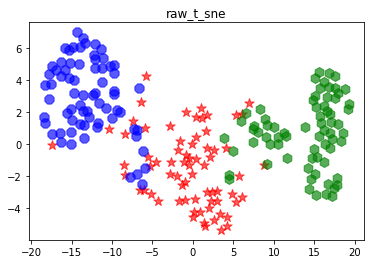

In [5]:
plot_tsne(dataset.values[:, :-2], dataset.values[:, -2], "raw_t_sne")

可以看出，数据集呈现一定的类别分布，分布有一定的重合。

## 三、K-Means算法实现
在sci-learn包中已经有K-Means算法的实现，但是为了更加了解算法，重新实现该算法。
具体步骤：
1. 随机选取index个样本点作为初始聚类中心
2. 计算样本到每个聚类中心的距离，将该样本指派到与其最近的聚类中心的类去。
3. 对于聚类结果，计算当前类中各个样本的均值作为新的聚类中心。
4. 如果迭代收敛(新旧聚类中心不变)或符合迭代条件，输出并结束；否则，继续回到步（2）。

In [6]:
import numpy as np


# 使用欧几里得距离
def cal_distance(x1, x2):
    return np.sqrt(np.sum((x1[:-2] - x2[:-2]) ** 2))


def k_means(datas, k):
    centers = {}
    n_datas = len(datas)
    # 1. 随机选取index个样本点作为初始聚类中心
    for idx, index in enumerate(np.random.choice(range(n_datas), size=k)):
        centers[idx] = datas[index]

    pre_centers = {}
    while True:
        clusters = {}
        for i in range(k):
            clusters[i] = []
        # 2. 计算样本到每个聚类中心的距离，将该样本指派到与其最近的聚类中心的类去。
        for data in datas:
            distances = []
            for idx in centers:
                distances.append(cal_distance(centers[idx], data))
            clusters[np.argmin(distances)].append(data)

        pre_centers = centers.copy()

        # 3. 对于聚类结果，计算当前类中各个样本的均值作为新的聚类中心。
        for idx in clusters.keys():
            centers[idx] = np.mean(clusters[idx][:-2], axis=0)

        is_terminal = False
        # 4. 如果迭代收敛(新旧聚类中心不变)或符合迭代条件，输出并结束；否则，继续回到步（2）。
        for idx in centers.keys():
            if (cal_distance(pre_centers[idx], centers[idx]) > 1e-8):
                is_terminal = False
                break
            is_terminal = True
        if is_terminal:
            break
    return centers, clusters

## 四、聚类分析

In [7]:
centers, clusters = k_means(dataset.values, 3)

class1 = np.array(clusters[0])
class2 = np.array(clusters[1])
class3 = np.array(clusters[2])

# 分类构造数据
class1 = np.hstack((class1, np.ones((class1.shape[0], 1))))
class2 = np.hstack((class2, 2 * np.ones((class2.shape[0], 1))))
class3 = np.hstack((class3, 3 * np.ones((class3.shape[0], 1))))
# 构造聚类后数据集
data = np.vstack((class1, class2, class3))


### 可视化聚类结果

/Users/lgds/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


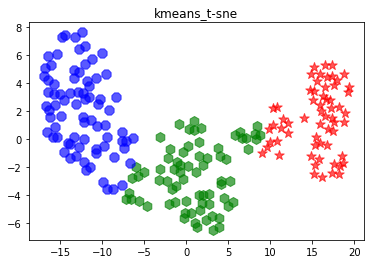

In [8]:
plot_tsne(data[:, :-3], data[:, -1], "kmeans_t-sne")

### 聚类结果评估
因为数据集提供了真实类别，因此可以采用调整兰德指数(Adjusted Rand index, ARI)，对聚类结果进行评估
> 假设U为外部评价，V是聚类结果，定义如下统计量:
> TP 在U中为同一类，且在V中也为同一类别的数据点对数
> TN 在U中不在同一类，且在V中也不属于同一类别的数据点对数
> FP 在U中不在同一类，但在V中维同一类的数据点对数
> FN 在U中为同一类，但在V中却隶属于不同类别的数据点对数
> 从而定义$RI(Rand Index)=\frac{TP+TN}{TP+FP+TN+FN}$
> $ARI=\frac{RI-E(RI)}{max(RI)-E(RI)},ARI\in [-1,1]$
> ARI值越大意味着聚类结果接近外部评价


In [9]:
from sklearn.metrics import adjusted_rand_score


def metric(label_true, label_pred):
    score = adjusted_rand_score(label_true, label_pred)
    print("ARI得分：{}".format(score))

In [10]:
metric(data[:, -3], data[:, -1])

ARI得分：0.7166198557361053


## 五、改进
由于初始聚类中心的的选择会严重影响K-Means算法的结果，因此可以改进K-Means算法的第一步，从而形成了K-Means++算法。
具体步骤：
1. 在数据集X中随机选择一个样本点作为第一个初始化的聚类中心
2. 接着计算每个样本与当前已有聚类中心之间的最短距离，用$D(x)$表示；然后计算每个样本点被选为下一个聚类中心的概率$P(x)(P(x)=\frac{D(x)^2}{\sum_{x\in X}D(x)^2})$，最后选择最大概率值所对应的样本点作为下一个簇中心
3. 重复第2步，直到选择出index个聚类中心
4. 对index个初始化的聚类中心，利用K-Means算法计算最终的聚类中心

In [11]:
def k_means_pp(datas, k):
    centers = {}
    n_datas = len(datas)
    # 在数据集X中随机选择一个样本点作为第一个初始化的聚类中心
    for idx, index in enumerate(np.random.choice(range(n_datas), size=1)):
        centers[idx] = datas[index]
    index = 0
    while (index < k):
        Dx2 = []
        for data in datas:
            distance = []
            for idx in centers:
                # 计算每个样本与当前已有聚类中心之间的最短距离的平方
                distance.append(cal_distance(centers[idx], data))
            Dx2.append(np.min(distance) ** 2)
        # 计算P(x)
        Px = [d / np.sum(Dx2) for d in Dx2]
        # 选择P(x)最大的样本点作为中心
        centers[index] = datas[np.argmax(Px)]
        index += 1

    # 使用K-Means计算聚类中心
    pre_centers = {}
    while True:
        clusters = {}
        for i in range(k):
            clusters[i] = []
        # 2. 计算样本到每个聚类中心的距离，将该样本指派到与其最近的聚类中心的类去。
        for data in datas:
            distances = []
            for idx in centers:
                distances.append(cal_distance(centers[idx], data))
            clusters[np.argmin(distances)].append(data)

        pre_centers = centers.copy()

        # 3. 对于聚类结果，计算当前类中各个样本的均值作为新的聚类中心。
        for idx in clusters.keys():
            centers[idx] = np.mean(clusters[idx][:-2], axis=0)

        is_terminal = False
        # 4. 如果迭代收敛(新旧聚类中心不变)或符合迭代条件，输出并结束；否则，继续回到步（2）。
        for idx in centers.keys():
            if (cal_distance(pre_centers[idx], centers[idx]) > 1e-8):
                is_terminal = False
                break
            is_terminal = True
        if is_terminal:
            break
    return centers, clusters

In [15]:
centers_p, clusters_p = k_means_pp(dataset.values, 3)

class1_p = np.array(clusters_p[0])
class2_p = np.array(clusters_p[1])
class3_p = np.array(clusters_p[2])

# 分类构造数据
class1_p = np.hstack((class1_p, np.ones((class1_p.shape[0], 1))))
class2_p = np.hstack((class2_p, 2 * np.ones((class2_p.shape[0], 1))))
class3_p = np.hstack((class3_p, 3 * np.ones((class3_p.shape[0], 1))))
# 构造聚类后数据集
data_p = np.vstack((class1_p, class2_p, class3_p))

可视化聚类结果，计算ARI

/Users/lgds/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


ARI得分：0.7103417092680225


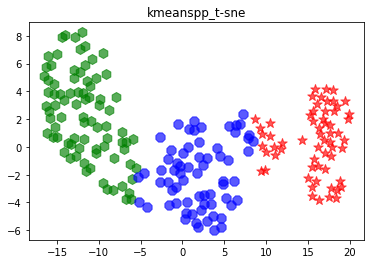

In [16]:
plot_tsne(data_p[:, :-3], data_p[:, -1], "kmeanspp_t-sne")
metric(data_p[:, -3], data_p[:, -1])

## 六、输出聚类结果

In [19]:
print("使用K-Means算法:")
print("class1 大小为:{}".format(len(class1)))
print("id分别为{",end="")
for id in class1[:,-2]:
    print("{},".format(int(id)),end="")
print("}")
print("class2 大小为:{}".format(len(class2)))
print("id分别为{",end="")
for id in class2[:,-2]:
    print("{},".format(int(id)),end="")
print("}")
print("class3 大小为:{}".format(len(class3)))
print("id分别为{",end="")
for id in class3[:,-2]:
    print("{},".format(int(id)),end="")
print("}")

使用K-Means算法
class1 大小为:61
id分别为{37,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,123,125,126,127,128,129,130,131,136,}
class2 大小为:72
id分别为{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,64,65,66,67,68,100,122,124,132,133,134,135,137,138,139,179,201,}
class3 大小为:77
id分别为{16,19,26,39,60,61,62,63,69,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,202,203,204,205,206,207,208,209,}


In [20]:
print("使用K-Means++算法:")
print("class1 大小为:{}".format(len(class1_p)))
print("id分别为{",end="")
for id in class1_p[:,-2]:
    print("{},".format(int(id)),end="")
print("}")
print("class2 大小为:{}".format(len(class2_p)))
print("id分别为{",end="")
for id in class2_p[:,-2]:
    print("{},".format(int(id)),end="")
print("}")
print("class3 大小为:{}".format(len(class3_p)))
print("id分别为{",end="")
for id in class3_p[:,-2]:
    print("{},".format(int(id)),end="")
print("}")

使用K-Means++算法:
class1 大小为:61
id分别为{37,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,123,125,126,127,128,129,130,131,136,}
class2 大小为:82
id分别为{16,19,23,26,27,39,59,60,61,62,63,69,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,}
class3 大小为:67
id分别为{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,20,21,22,24,25,28,29,30,31,32,33,34,35,36,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,64,65,66,67,68,100,122,124,132,133,134,135,137,138,139,}


## 七、思考
1. 根据数据集真实标签产生的可视化图像可知，数据集虽然有较为明显的三个聚类分布，但聚类之间有部分重合，因此对于聚类算法的结果与真实结果可能有较大偏差。两个算法的ARI结果都在0.7左右，验证了这一点。
2. K-Means++主要是为了改进K-Means随机选择初始可能导致陷入局部最优的情况，而这种情况在此次聚类中并没有出现，因此两个算法的结果表现出一定的相似性
3. 此数据集有7个属性，而这7个属性之间有一定的重复，如籽粒长度、籽粒宽度和面积，并且不同属性对于不同类的增益程度不同，因此可以考虑对属性乘以权重（用于突出不同属性对不同类的重要程度/增益效果）